In [60]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [61]:
# import os
# os.chdir('/content/drive/MyDrive/Colab/gp/lab5')
# os.listdir()

In [62]:
# !pip install gpflow
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.kernels import White, RBF
from gpflow.likelihoods import Gaussian
from deep_gp import DeepGP
import matplotlib.pyplot as plt

# Deep Gaussian Processes

-------------------

# Part 1 - Sampling From a Deep GP (worth 1 point)

#### You are provided with the following ingredients with which to build a GP model

In [63]:
np.random.seed(111)
N = 500
x = np.linspace(-20, 20, num=N)

gp_var = 1.0  # GP variance
gp_len = 1.0  # GP lengthscale

def rbf_kernel(x1, x2):
    x1 = x1.reshape(-1, 1, 1)
    x2 = x2.reshape(1, -1, 1)
    r = np.sum(x1 - x2, axis=-1)
    return gp_var * np.exp(-0.5 * np.square(r) / np.square(gp_len))


def zero_mean(X):
    return np.zeros_like(X.reshape(-1, ))


def identity_mean(X):
    return X.reshape(-1, )

**Task 1a**: Generate a sample from a 3-layer deep GP with **zero mean** and an **RBF kernel**. Use the inputs, x, and parameters given above. Plot the sample path and the covariance matrix in each layer.

**Do you notice any strange behaviour in the sample path and/or covariance matrix? Write a short explanation of the behaviour and why you think it may be occuring.**

hint 1: you can use np.random.multivariate_normal() to sample from a Gaussian distribution. ***Note: you may need to add a small value to the diagonal of the covariance matrix to prevent numerical issues during sampling, e.g. + 1e-10 * np.eye(N)***

hint 2: use plt.imshow() to plot a covariance matrix

hint 3: always plot the initial inputs, x, on the x-axis of the sample plots.

In [64]:


tmp = x

sample_list = []
covs_list = []
for i in range(3):
    means = zero_mean(tmp)
    assert means.shape == (N,)
    covs = rbf_kernel(tmp,tmp) + 1e-10 * np.eye(N)
    assert covs.shape == (N,N)
    tmp = np.random.multivariate_normal(means, covs)
    assert tmp.shape == (N,)

    sample_list.append(tmp)
    covs_list.append(covs)


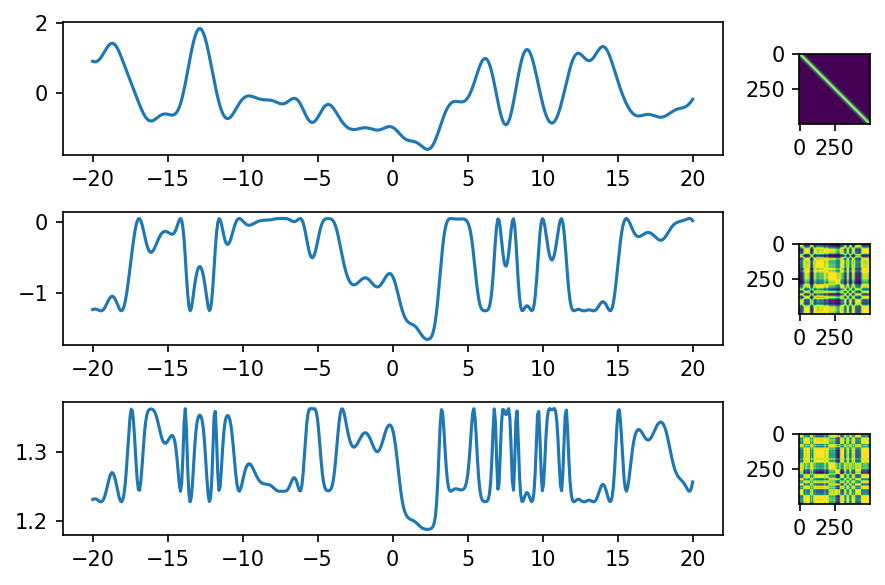

In [65]:
plt.figure(1,dpi=150)
plt.title('3-layer deep GP')
for i in range(3):
    ax = plt.subplot2grid((3,6),(i,0),colspan=5)
    ax.plot(x,sample_list[i])
    ax = plt.subplot2grid((3,6),(i,5))
    ax.imshow(covs_list[i])

plt.tight_layout()
plt.show()

## Conclution
Samples path generated from higher layer tend to become more nonlinear and the covariances between 2 remote points also have a higher relavance in comparison with the signle layer gaussian. This may due to the conbinations of nonlinear transformations in each layer.

**Task 1b**: Now generate a sample from a 3-layer deep GP, now with the **identity mean function for the first two layers**, and a **zero mean function for the final layer**. Plot the samples from each layer and the covariance matrices.

**Do you notice any differences in the behaviour between this sample and the previous one? Write a short explanation.**

In [66]:
sample_list = []
covs_list = []
tmp = x
for i in range(3):
    if i == 2:
        means = zero_mean(tmp)
        assert means.shape == (N,)
        covs = rbf_kernel(tmp,tmp) + 1e-10 * np.eye(N)
        assert covs.shape == (N,N)
        tmp = np.random.multivariate_normal(means, covs)
        assert tmp.shape == (N,)
    else:
        means = identity_mean(tmp)
        assert means.shape == (N,)
        covs = rbf_kernel(tmp,tmp) + 1e-10 * np.eye(N)
        assert covs.shape == (N,N)
        tmp = np.random.multivariate_normal(means, covs)
        assert tmp.shape == (N,)

    sample_list.append(tmp)
    covs_list.append(covs)

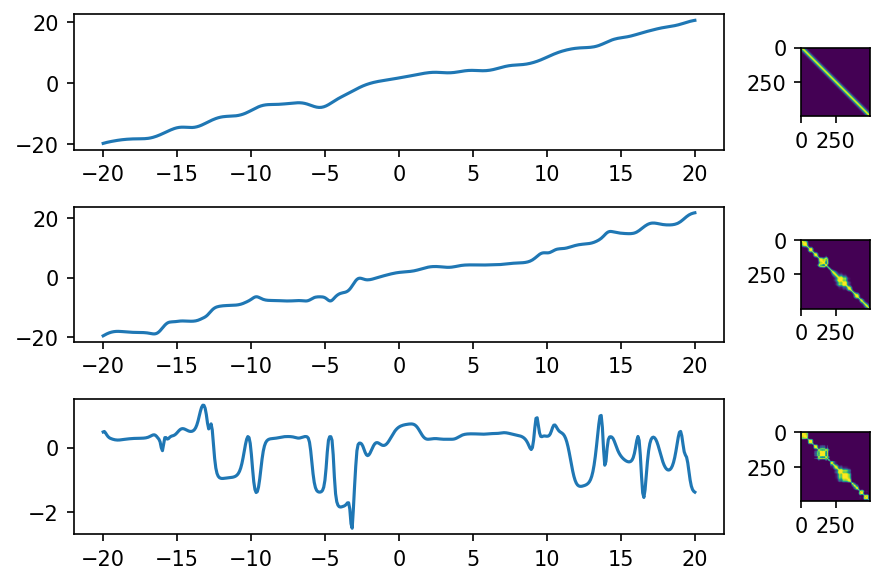

In [67]:
plt.figure(1,dpi=150)
plt.title('3-layer deep GP')
for i in range(3):
    ax = plt.subplot2grid((3,6),(i,0),colspan=5)
    ax.plot(x,sample_list[i])
    ax = plt.subplot2grid((3,6),(i,5))
    ax.imshow(covs_list[i])

plt.tight_layout()
plt.show()

# Conclusion
The identity kernel strenthen the relavance between close points, while the zero mean kernel introduce the non-linearity to the model, so we can get a complex, non-linear posterior of `f`

-----------------------

# Part 2 - Training a Deep GP (worth 1 point)

Here we generate some training data using the step function

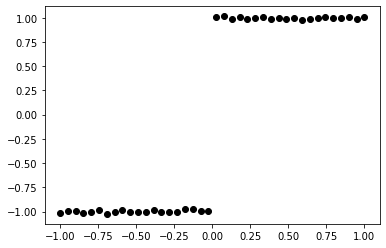

In [68]:
tf.random.set_seed(0)
np.random.seed(123)
N = 40
X_train = np.linspace(-1, 1, N)[:, None]
f_step = lambda x: -1 if x < 0 else 1.
Y_train = np.reshape([f_step(x) for x in X_train], X_train.shape) + np.random.randn(*X_train.shape) * 1e-2
Xs = np.linspace(-2., 2, 300)[:, None]  # test inputs
plt.scatter(X_train, Y_train, color='k');

**Task 2a:** The ELBO calculation has been removed from the deep GP implementation. **Implement the ELBO yourself using the derivation on slide 16 of the lecture.**

A custom deep GP class has been created below. You are only required to finish the implementation of the ELBO, using the ingredients given in the code comments.

You will need the following ingredients:

- samples
`self.predict_f()` produces samples from the `marginal`
$$q(f_{L,n,s})$$

- integral
now use `self.likelihood.variational_expectations(F_mean, F_var, Y)` to evaluate following:
$$ \int q(f_{L,n,s}) \ln p(y_n | f_{L,n,s}) \mathrm{d} f_{L,n,s} $$

- KL
Compute the KL term. The KL for a single layer, `i`, can be computed as follows: `gpflow.kullback_leiblers.gauss_kl(self.layers[i].q_mu, self.layers[i].q_sqrt, K=self.layers[i].Ku)`



In [69]:
class MyDeepGP(DeepGP):

    def elbo(self, data):
        """
        Implement the ELBO here using the derivation on slide 16 of the lecture notes
        :param data: Tuple of two tensors for input data X and labels Y.
        :return: Tensor representing ELBO.
        """
        X, Y = data  # mini-batch data for the current training step
        N_star = X.shape[0]  # number of points in the mini-batch
        N = self.num_data  # total number of data points
        S = self.num_samples  # the number of samples used to evaluate the marginals, q(f_{L,n})
        
        ############################################

        # the initial layer
        F_mean, F_var = self.predict_f(X, num_samples=S, full_cov=False)

        KL = 0
        for i in range(len(self.layers)):
            KL += gpflow.kullback_leiblers.gauss_kl(self.layers[i].q_mu, self.layers[i].q_sqrt, K=self.layers[i].Ku)

        sum_of_intergral = self.likelihood.variational_expectations(F_mean, F_var, Y)
        assert sum_of_intergral.shape == (S,N_star)

        first_term = N * tf.reduce_sum(sum_of_intergral) / (S * N_star)
        ELBO = first_term - KL

        ############################################
        
        # You will need the following ingredients:

        # self.predict_f() produces samples from the marginal, q(f_{L,n,s}):
        
        # now use self.likelihood.variational_expectations(F_mean, F_var, Y) to evaluate following:
        # \int q(f_{L,n,s}) ln p(y_n | f_{L,n,s}) d f_{L,n,s}
        
        # first_term = tf.reduce_mean((N/N_star)  * tf.reduce_mean(sum_of_intergral,axis=0))
        
        # Compute the KL term. The KL for a single layer, i, can be computed as follows:
        # gpflow.kullback_leiblers.gauss_kl(self.layers[i].q_mu, self.layers[i].q_sqrt, K=self.layers[i].Ku)    
        
        
        return ELBO

Now train the model and plot the posterior by running the following code (no modification needed):

iter 100, ELBO: -73.7066
iter 200, ELBO: -61.6740
iter 300, ELBO: -50.3141
iter 400, ELBO: -31.8037
iter 500, ELBO: -6.7534
iter 600, ELBO: 15.6531
iter 700, ELBO: 7.2125
iter 800, ELBO: -31.6337
iter 900, ELBO: 13.9980
iter 1000, ELBO: 35.0357
iter 1100, ELBO: 38.2354
iter 1200, ELBO: 27.0481
iter 1300, ELBO: 43.9145
iter 1400, ELBO: 48.0433
iter 1500, ELBO: 47.7657
iter 1600, ELBO: 45.5314
iter 1700, ELBO: 47.7403
iter 1800, ELBO: 59.0295
iter 1900, ELBO: 44.2668
iter 2000, ELBO: -8.6135
iter 2100, ELBO: 39.8014
iter 2200, ELBO: 42.6641
iter 2300, ELBO: 43.1182
iter 2400, ELBO: 52.7095
iter 2500, ELBO: 57.1848
iter 2600, ELBO: 45.6522
iter 2700, ELBO: 55.1675
iter 2800, ELBO: 39.4158
iter 2900, ELBO: 9.5427
iter 3000, ELBO: 11.3321
iter 3100, ELBO: 38.8216
iter 3200, ELBO: 45.0940
iter 3300, ELBO: 49.4296
iter 3400, ELBO: 51.9304
iter 3500, ELBO: 50.7199
iter 3600, ELBO: 54.6481
iter 3700, ELBO: 52.1773
iter 3800, ELBO: 52.5209
iter 3900, ELBO: 51.8572
iter 4000, ELBO: 56.6712
iter 4

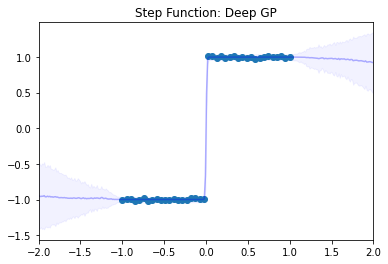

In [70]:
## Helper functions used to build and train the deep GP

def make_deep_GP(num_layers, X, Y, Z):
    kernels = []
    layer_sizes = []
    for l in range(num_layers):
        kernel = RBF(lengthscales=0.2, variance=1.0) + White(variance=1e-4)
        kernels.append(kernel)
        layer_sizes.append(1)

    dgp = MyDeepGP(X, Y, Z, kernels, layer_sizes, Gaussian(variance=1), num_samples=20)

    # init hidden layers to be near deterministic
    for layer in dgp.layers[:-1]:
        layer.q_sqrt.assign(layer.q_sqrt * 1e-2)
    return dgp


@tf.function()
def training_step(model, opt):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        obj = -model.elbo((X_train, Y_train))
        gradients = tape.gradient(obj, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return obj




## Now train the model and plot the result

M = 20  # num inducing points
num_layers = 3  # number of layers
Z_init = np.random.uniform(-1, 1, M)[:, None]
dgp = make_deep_GP(num_layers, X_train, Y_train, Z_init)
optimizer = tf.optimizers.Adam(learning_rate=0.01, epsilon=1e-08)

num_iters = 5000

for it in range(1, num_iters + 1):
    objective = training_step(dgp, optimizer)
    if np.mod(it, 100) == 0:
        print('iter %2d, ELBO: %1.4f' % (it, -objective.numpy()))

m_test, v_test = dgp.predict_y(Xs, num_samples=1000)
m_test, v_test = tf.reduce_mean(m_test, axis=0), tf.reduce_mean(v_test, axis=0)
lb = m_test[:, 0] - 1.96 * v_test[:, 0] ** 0.5
ub = m_test[:, 0] + 1.96 * v_test[:, 0] ** 0.5

plt.plot(Xs, m_test, color='b', alpha=0.3)
plt.fill_between(Xs[:, 0], lb, ub, color='b', alpha=0.05, label='95% confidence')
plt.xlim(min(Xs), max(Xs))

plt.title('Step Function: Deep GP')
plt.scatter(X_train, Y_train);

**Task 2b:** Plot the model output from each layer. **Write a brief explanation of what role you think each layer is playing in inference.**

In [71]:
# Prediction in the deep GP is also done via sampling 
# The following code produces 50 predictive samples from each layer.
_, layers_means, layers_variances = dgp.predict_all_layers(Xs, num_samples=50, full_cov=False)
# You can get a good estimate of the posterior predictive mean and variance by taking the mean of the samples.

In [72]:
print(np.array(_).shape)
print(np.array(layers_means).shape)
print(np.array(layers_variances).shape)

(3, 50, 300, 1)
(3, 50, 300, 1)
(3, 50, 300, 1)


In [73]:
layer_m = []
layer_v = []
Fs = []
for i in range(3):
    Fs.append(np.mean(_[i],axis=0))
    layer_m.append(np.mean(layers_means[i],axis=0))
    layer_v.append(np.mean(layers_variances[i],axis=0))


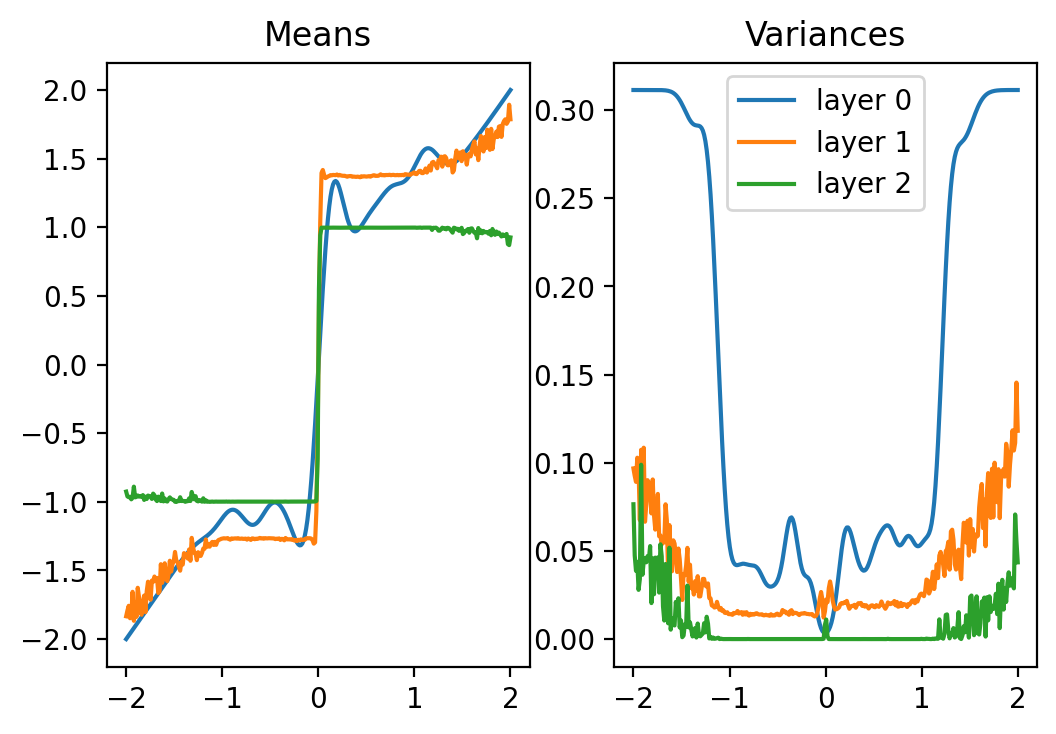

In [74]:
plt.figure(dpi=200)
ax = plt.subplot2grid((1,2),(0,0))
ax.set_title('Means')
for i in range(3):
    ax.plot(Xs, layer_m[i], label=f'layer {i}')

ax = plt.subplot2grid((1,2),(0,1))
ax.set_title('Variances')
for i in range(3):
    ax.plot(Xs, layer_v[i], label=f'layer {i}')

plt.legend()
plt.show()

# Part 3: Model inference of lecture 9 (worth 2 points)

**Task 3**: Pick some small data set (or a subset of a big data set). Study a GP model of your own choosing, where the latent values can't be integrated out analytically. 

Examples (See Lecture 9):
- normal(mu,exp(eta)), mu ~ GP, eta ~ GP
  e.g. https://avehtari.github.io/casestudies/Motorcycle/motorcycle.html
- increasing magnitude model
  e.g. https://avehtari.github.io/casestudies/Birthdays/birthdays.html
- non-normal observation model, like Bernoulli, Poisson or negative-binomial
  e.g. http://avehtari.github.io/BDA_R_demos/demos_rstan/trafficdeaths.html

You may use any software you like (Stan, gpflow, gpytorch), and you may use full MCMC or
integrate over latent values using Laplace, EP or VI.

**Write a short report**:
1. describe your model and approach
2. what are optimized parameters vs. posterior of parameters
3. show predictive distribution with optimization vs. posterior predictive

For those familiar with GPflow, see
https://gpflow.readthedocs.io/en/develop/notebooks/advanced/mcmc.html#Example-3:-Fully-Bayesian-inference-for-generalized-GP-models-with-HMC

For those familiar with PyMC3, see
https://docs.pymc.io/notebooks/GP-Latent.html

**Hint**:
- Check the Lecture 9 video
- Studying the motorcycle casestudy is a good starting point
- If you have questions, check the course Slack channel https://join.slack.com/t/gp2021e4075/shared_invite/zt-l0x4rfc5-go1vZngUsvq9ix9wdMQAIQ

In [75]:
# !pip install gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import gpflow
from gpflow.kernels import White, RBF
from gpflow.ci_utils import ci_niter
from gpflow import set_trainable
np.random.seed(123)
tf.random.set_seed(123)
rng = np.random.RandomState(123)

In [76]:
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-8)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

%matplotlib inline

# Randomly draw dataset

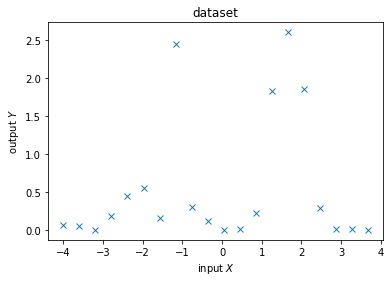

In [77]:

N = 100
# X_original = np.linspace(-4, 4, N)
# Y_original = rng.exponential(np.sin(X_original) ** 2)
X_original = np.load('x.npy')
Y_original = np.load('y.npy')
# choose reducing points
equal_idx = np.arange(0,100,step=5)
X = X_original[equal_idx]
Y = Y_original[equal_idx]

plt.figure()
plt.plot(X, Y, "x")
plt.xlabel("input $X$")
plt.ylabel("output $Y$")
plt.title("dataset")
plt.show()

data = (X[:, None], Y[:, None])


In [78]:
np.save('x.npy',X_original)
np.save('y.npy',Y_original)

# GP Model

In [79]:
kernel = gpflow.kernels.Matern32() + gpflow.kernels.Constant()
likelihood = gpflow.likelihoods.Exponential()
model = gpflow.models.GPMC(data, kernel, likelihood)

model.kernel.kernels[0].lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[0].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[1].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))

# model.kernel.kernels[2].lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
# model.kernel.kernels[2].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))

gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.kernel.kernels[0].lengthscales,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.kernel.kernels[1].variance,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.V,Parameter,Identity,Normal,True,"(20, 1)",float64,[[0....


# Optimizer (MAP)

In [80]:
optimizer = gpflow.optimizers.Scipy()
maxiter = ci_niter(3000)
_ = optimizer.minimize(
    model.training_loss, model.trainable_variables, options=dict(maxiter=maxiter)
)

In [81]:
num_burnin_steps = ci_niter(600)
num_samples = ci_niter(1000)

hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, _ = run_chain_fn()

## Test data

- We calculate the means
- We plot the distribution of predictive posterior

In [82]:
Xtest = np.linspace(-4, 4, 100)[:, None]
f_samples = []

# calculate the means of posteriro predictions
for i in range(num_samples):
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(Xtest, 5)
    f_samples.append(f)
f_samples = np.vstack(f_samples)


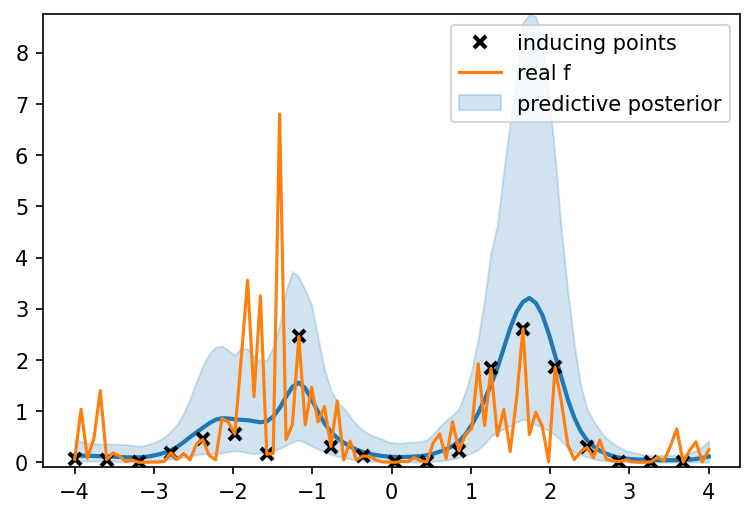

In [83]:
rate_samples = np.exp(f_samples[:, :, 0])
plt.figure(dpi=150)

# average mean of posterior predictions
(line,) = plt.plot(Xtest, np.mean(rate_samples, 0), lw=2)

plt.fill_between(
    Xtest[:, 0],
    np.percentile(rate_samples, 5, axis=0),
    np.percentile(rate_samples, 95, axis=0),
    color=line.get_color(),
    alpha=0.2,
    label='predictive posterior'
)

# plot the rest and optimal
plt.plot(X, Y, "kx", mew=2, label='inducing points')
plt.plot(X_original, Y_original, label='real f')
plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)))
plt.legend()
plt.show()

# Parameter posterior with optimization

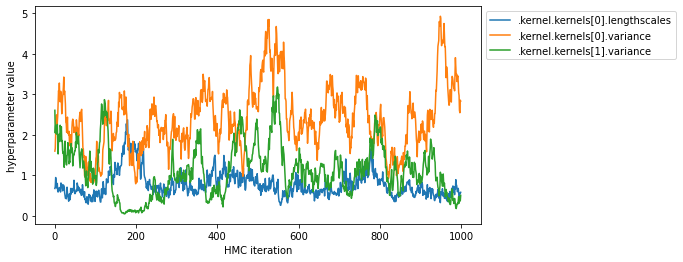

In [84]:
parameter_samples = hmc_helper.convert_to_constrained_values(samples)
param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}
name_to_index = {param_to_name[param]: i for i, param in enumerate(model.trainable_parameters)}
hyperparameters = [
    ".kernel.kernels[0].lengthscales",
    ".kernel.kernels[0].variance",
    ".kernel.kernels[1].variance",
]


plt.figure(figsize=(8, 4))
for param_name in hyperparameters:
    plt.plot(parameter_samples[name_to_index[param_name]], label=param_name)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("HMC iteration")
_ = plt.ylabel("hyperparameter value")

In [85]:
hyperparameters

['.kernel.kernels[0].lengthscales',
 '.kernel.kernels[0].variance',
 '.kernel.kernels[1].variance']

Text(0, 0.5, 'Matern32 kernel variances')

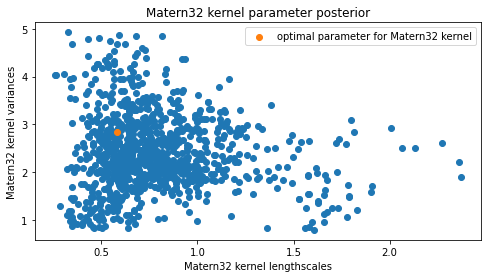

In [86]:
k0m = parameter_samples[name_to_index['.kernel.kernels[0].lengthscales']]
k0v = parameter_samples[name_to_index['.kernel.kernels[0].variance']]
plt.figure(figsize=(8, 4))
plt.title('Matern32 kernel parameter posterior')
plt.scatter(k0m, k0v)
plt.scatter(k0m[-1],k0v[-1], label='optimal parameter for Matern32 kernel')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Matern32 kernel lengthscales")
plt.ylabel("Matern32 kernel variances")